# Описание датасета

По заданию используется датасет Tomato Leaf Dataset, скачанный с ресурса Kaggle. Набор данных содержит изображения листьев томатов, предназначенные для классификации по типам заболеваний. \
Данные представлены в виде папок, каждая из которых соответствует 9 классам заболеваний: Bacterial Spot, Early Blight, Late Blight, Leaf Mold, Septoria Leaf Spot, Spider Mites, Target Spot, Tomato Mosaic Virus, Tomato Yellow Leaf Curl Virus. Также присутствует класс здоровых листьев – Healthy. \
Хоть CNN автоматически извлекает признаки, можно выделить важные визуальные характеристики, такие как форма и цвет пятен, структура повреждений, общий оттенок листа, текстура поверхности.


# Подготовка данных

Импорт библиотек.

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Распаковка архива.

In [ ]:
zip_path = '/content/train.zip'
extract_path = '/content/train'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Реализуется подсчет количества изображений в каждой категории, чтобы понять, насколько сбалансированы данные. Вывод графика распределения изображений по классам.

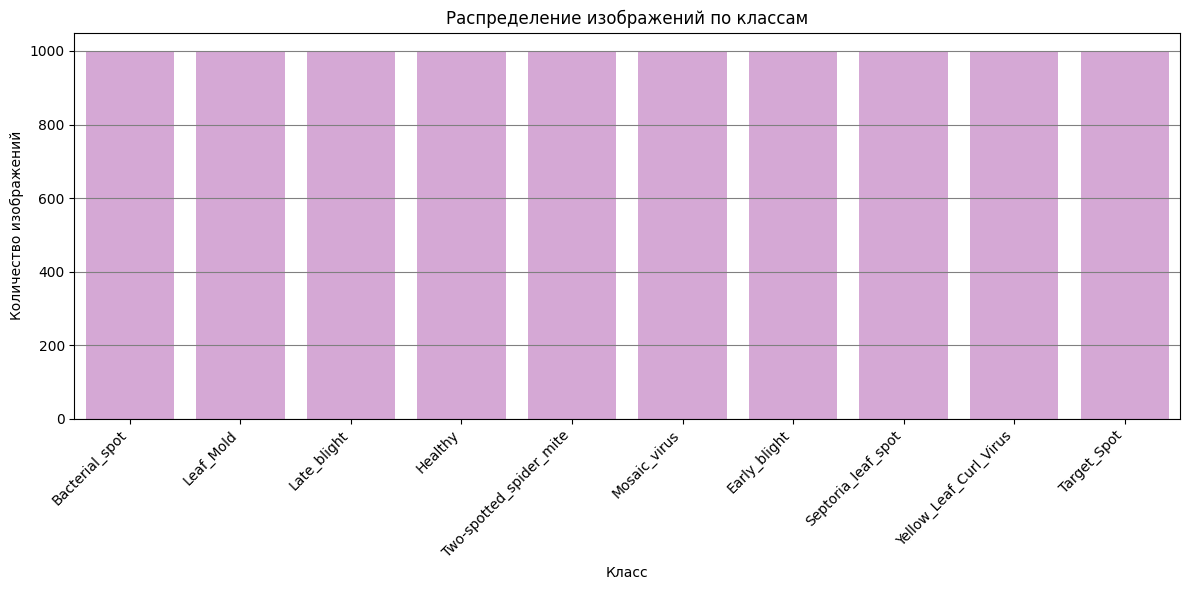

In [ ]:
dataset_path = '/content/train/train'

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = num_images

plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), color='plum')
plt.xticks(rotation=45, ha='right')
plt.title('Распределение изображений по классам')
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.grid(True, color='gray', axis='y')
plt.tight_layout()
plt.show()

Данный график подтверждает, что датасет хорошо сбалансирован по классам. Это обеспечит высокую обобщающую способность. В таком случае не требуется балансировка классов. \
Далее выводятся несколько случайных изображений из одной категории.

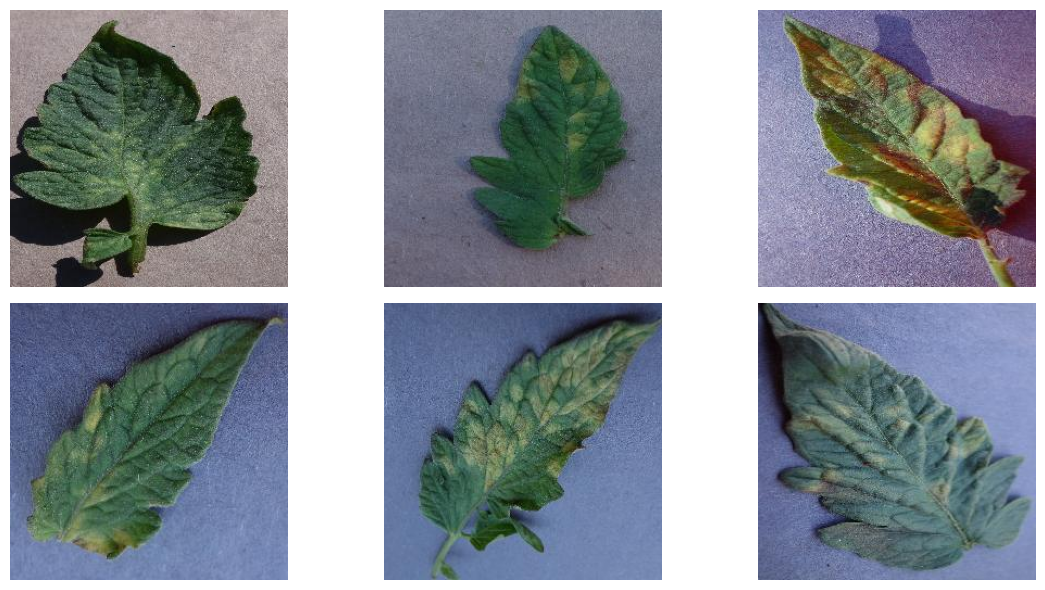

In [ ]:
class_name = 'Leaf_Mold'
class_dir = os.path.join(dataset_path, class_name)

images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(images, 6)

plt.figure(figsize=(12, 6))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(class_dir, img_name)
    img = plt.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Применение rescale=1./255 для нормализации изображений в диапазон [0, 1]. Настройка генератора данных с аугментацией.

Found 10000 images belonging to 10 classes.


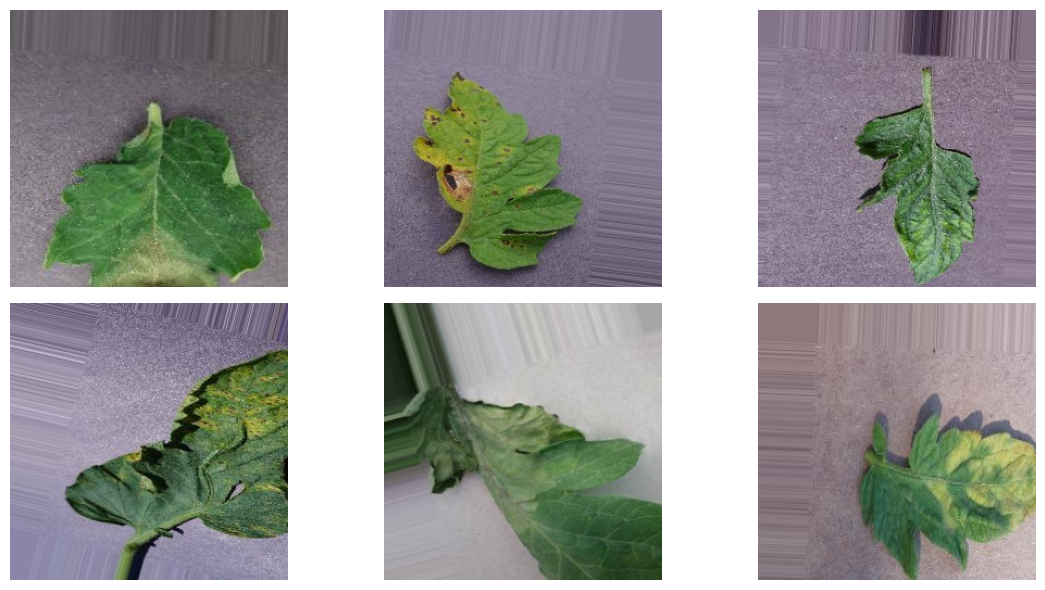

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

generator = datagen.flow_from_directory(
    '/content/train/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

images, labels = next(generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Разработка архитектуры CNN

Создается архитектура сверточной нейронной сети, которая предназначена для классификации изображений на 10 классов. Выводится сводка архитектуры модели.

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,266 (56.61 MB)

 Trainable params: 14,840,266 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение модели

In [ ]:
train_generator = datagen.flow_from_directory(
    '/content/train/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/train/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1280s 5s/step - accuracy: 0.1990 - loss: 2.2986 - val_accuracy: 0.5136 - val_loss: 1.3238
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1241s 5s/step - accuracy: 0.5048 - loss: 1.4233 - val_accuracy: 0.6341 - val_loss: 1.0676
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1235s 5s/step - accuracy: 0.6161 - loss: 1.1221 - val_accuracy: 0.7520 - val_loss: 0.7419
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1235s 5s/step - accuracy: 0.6552 - loss: 0.9749 - val_accuracy: 0.7576 - val_loss: 0.6784
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1236s 5s/step - accuracy: 0.7020 - loss: 0.8548 - val_accuracy: 0.7863 - val_loss: 0.6186
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1317s 5s/step - accuracy: 0.7061 - loss: 0.8372 - val_accuracy: 0.7666 - val_loss: 0.6462
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1244s 5s/step - accuracy: 0.7487 - loss: 0.7082 - val_accuracy: 0.8065 - val_loss: 0.5190
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1281s 5s/step - accuracy: 0.7690 - loss: 0.6568 - 

# Оценка качества модели

Вывод метрик.

In [ ]:
validation_generator_eval = datagen.flow_from_directory(
    '/content/train/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

y_pred = model.predict(validation_generator_eval, steps=int(np.ceil(validation_generator_eval.samples / 32)))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator_eval.classes

print(classification_report(y_true, y_pred_classes, target_names=validation_generator_eval.class_indices.keys()))


Found 2000 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step
                         precision    recall  f1-score   support

         Bacterial_spot       0.87      0.85      0.86       200
           Early_blight       0.80      0.85      0.83       200
                Healthy       0.91      0.99      0.95       200
            Late_blight       0.90      0.74      0.81       200
              Leaf_Mold       0.76      0.97      0.85       200
           Mosaic_virus       0.84      0.97      0.90       200
     Septoria_leaf_spot       0.85      0.77      0.81       200
            Target_Spot       0.71      0.83      0.76       200
Two-spotted_spider_mite       0.89      0.59      0.71       200
 Yellow_Leaf_Curl_Virus       0.98      0.86      0.91       200

               accuracy                           0.84      2000
              macro avg       0.85      0.84      0.84      2000
           weighted avg       0.85      0.84      0.84      2000



Полученные метрики после обучения модели и  оценки на валидационной выборке показывают, что сверточная нейронная сеть успешно справляется с задачей многоклассовой классификации листьев томатов по типам заболеваний. Общая точность на тестовой выборке составляет 84%, что является хорошим результатом. \
Построение матрицы ошибок.

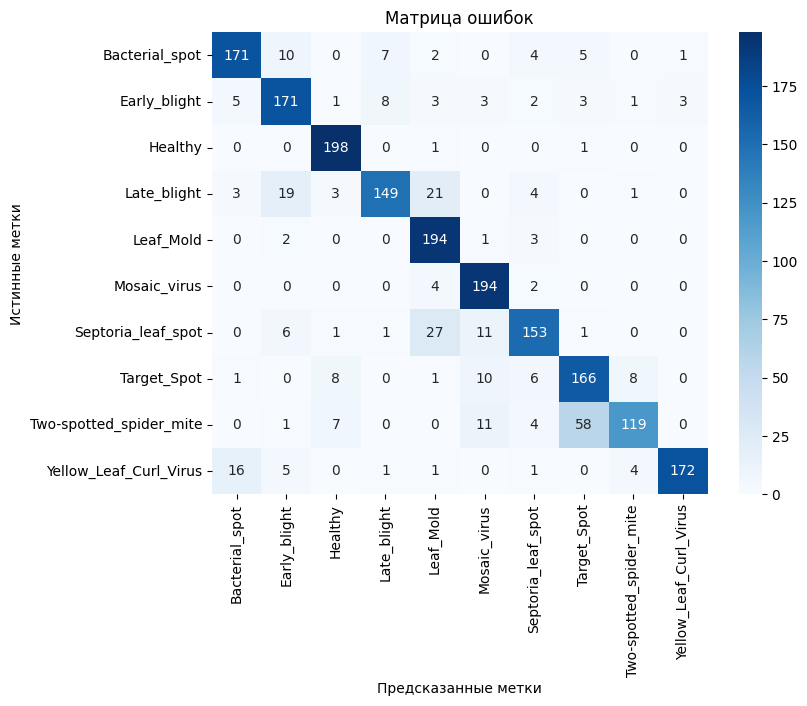

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

Модель работает хорошо, особенно по большинству классов, и точно распознаёт выраженные болезни. Наибольшие ошибки происходят внутри схожих категорий, например Septoria_leaf_spot от Spider_mite. \
Построение графиков изменения потерь и изменения точности.

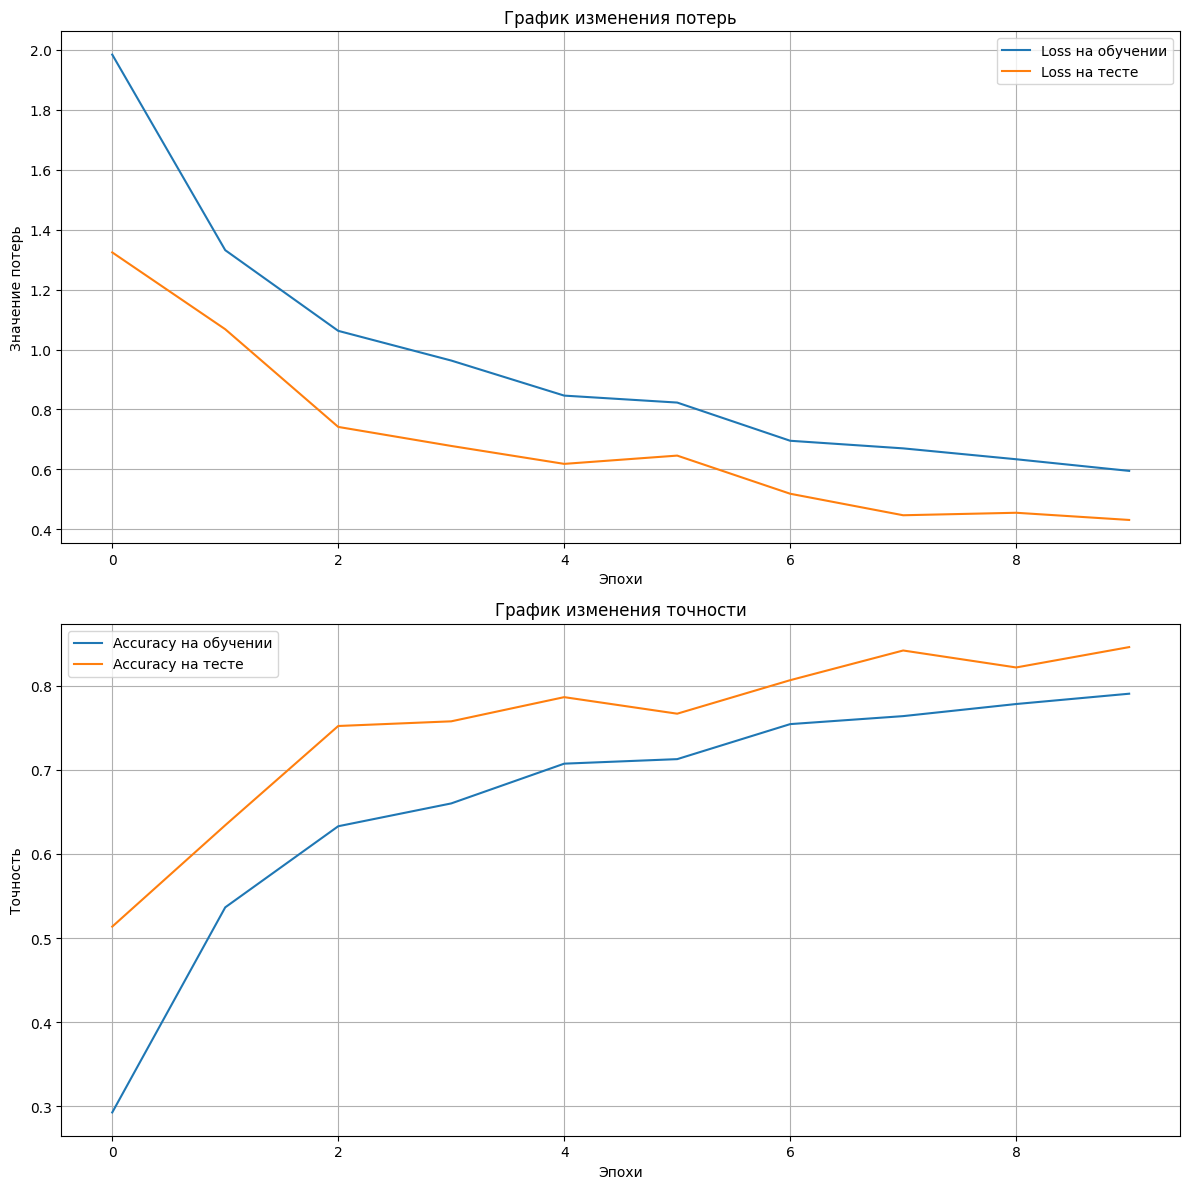

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Loss на обучении')
plt.plot(history.history['val_loss'], label='Loss на тесте')
plt.title('График изменения потерь')
plt.xlabel('Эпохи')
plt.ylabel('Значение потерь')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Accuracy на обучении')
plt.plot(history.history['val_accuracy'], label='Accuracy на тесте')
plt.title('График изменения точности')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Графики изменения потерь и точности позволяют сделать вывод о том, что обучение прошло успешно. На графике потерь видно, что как на обучающей, так и на валидационной выборках значения loss постепенно и устойчиво снижаются. Особенно заметное уменьшение наблюдается в первые эпохи. В последующих эпохах темп снижения потерь становится более пологим, но сохраняется до конца процесса обучения. \
График точности показывает, что уже с первых эпох точность на валидационной выборке выше, чем на обучающей, и в целом обе линии растут синхронно. Это говорит о том, что модель хорошо обобщает знания, не переобучается и не теряет способность к распознаванию новых данных.
